In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from torch_nf.conditional_nf import NormFlow, ConditionedNormFlow
from torch_nf.error_formatters import dbg_check
from torch_nf.bijectors import ToInterval
import scipy.stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Parameterizing the two-network arch.

In [2]:
D = 4 
arch_type = 'affine'
hidden_layers = [50]

### Define the system.

In [ ]:
class System(object):
    def __init__(self, D):
        super(System, self).__init__()
        self.support_layer = None
        
    def simulate(self, D):
        raise NotImplementedError()
        
    def sample_prior(self, M):
        raise NotImplementedError()
        
class HebbLearn(System):
    def __init__(self, num_neurons=20, N_x = 50):
        super(HebbLearn, self).__init__()
        self.D = 4
        self.lb = np.array([1e-6, 1e-6, -4., 0.])
        self.ub = np.array([2e-1, 2e-1, 4., 20.])
        self.support_layer = ToInterval(self.D, self.lb, self.ub)
        
        self.num_neurons = num_neurons
        self.N_x = N_x
        
        df_fac = 5
        df = num_neurons*df_fac
        scale = df*np.eye(num_neurons)
        IW = scipy.stats.invwishart(df=df, scale=scale)
        Sigma = IW.rvs(1)
        mvn = scipy.stats.multivariate_normal(mean=np.zeros(num_neurons), cov=Sigma)
        x = mvn.rvs(N_x) 
        
    def simulate():
        


### Define the input.

### Hebbian learning function

In [4]:
w0 = np.random.normal(0., 1., (num_neurons,))
sigma_eps = 0.0001
def hebb(z, traj=False):
    N = z.shape[0]
    alpha, beta, theta_x, b = np.hsplit(z, 4)
    N_x, num_neurons = x.shape
    w = np.tile(w0[None,:], (N, 1))
    lb, ub = -b, b
    num_passes = 2
    if traj:
        ws = []
    for i in range(num_passes):
        for j in range(N_x):
            x_j= np.expand_dims(x[j], 0)
            y = np.dot(w, x_j.T)
            delta_w = alpha*y*(x_j-theta_x) - beta*(y**2)*w
            eps = np.random.normal(0., sigma_eps, (N,num_neurons))
            w = w + delta_w + eps
            for k in range(N):
                w[k][w[k]<lb[k]] = lb[k]
                w[k][w[k]>ub[k]] = ub[k]
            if traj:
                ws.append(w)
    if traj:
        return np.array(ws)
    else: 
        return w

### The data distribution

[[ -9.95583754   9.49185825  10.           1.29460007   8.08204649
  -10.           7.57043299  -9.97197984   7.2605225  -10.
    8.79694132  10.           6.84614666  -7.71365115   2.63861269
    9.99090573  -7.87416749  10.           8.0196033    4.72480603]]


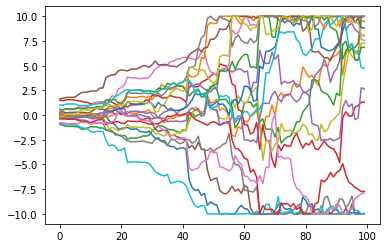

In [5]:
N_x0 = 1
z = np.array([0.02, 0.00, 0., 10])
z = np.tile(np.expand_dims(z, 0), (N_x0, 1))
w = hebb(z, traj=False)
x0 = np.reshape(w, (1, N_x0*num_neurons))
print(x0)

ws = hebb(z, traj=True)
plt.plot(ws[:,0,:])
plt.show()

In [6]:
z_labels = ['alpha', 'beta', 'theta_x', 'b']
def plot_dist(z, log_q_z, z_labels=z_labels):
    print('z', z.shape)
    print('log_q_z', log_q_z.shape)
    df = pd.DataFrame(z)
    if z_labels is None:
        z_labels = ["z%d" % d for d in range(1, D + 1)]
    df.columns = z_labels
    df["log_q_z"] = log_q_z

    log_q_z_std = log_q_z - np.min(log_q_z)
    log_q_z_std = log_q_z_std / np.max(log_q_z_std)
    cmap = plt.get_cmap("viridis")
    g = sns.PairGrid(df, vars=z_labels)
    g = g.map_diag(sns.kdeplot)
    g = g.map_upper(plt.scatter, color=cmap(log_q_z_std))

    g = g.map_lower(sns.kdeplot)
    return g

### Define the prior distribution.

In [7]:
def uniform(a, b, N):
    z = np.random.uniform(a, b, (N,))
    p_z = 1./(b-a)*np.ones((N,))
    return z, p_z

def log_uniform(a, b, N):
    exp = np.random.uniform(a, b, (N,))
    z = 10.**exp
    p_z = np.log(10.)*z
    return z, p_z
    

def SNPE_prior(r, N, cnf, x0):
    if (r==1):
        alpha, p_alpha = log_uniform(-5, -1, N)
        beta, p_beta = log_uniform(-5, -1, N)
        theta_x, p_theta_x = uniform(-3, 3, N)
        b, p_b = uniform(1, 20., N)
        z = np.stack((alpha, beta, theta_x, b), axis=1)
        
        # calc prior log prob
        p_z = np.stack((p_alpha, p_beta, p_theta_x, p_b), axis=1)
        p_z = np.prod(p_z, axis=1)
        
        z = torch.tensor(z).float()
        p_z = torch.tensor(p_z).float()
        return z, p_z
    else:
        z, log_q_z = cnf(x=x0, N=N)
        return z[0], torch.exp(log_q_z[0])

### Run SNPE

In [8]:
def clip_grads(params, clip):
    for param in params():
        param.grad.data.clamp_(-clip, clip)
    return None

In [9]:
import time

N = 500
def train_nde(cnf, x0, num_iters=1000):
    optimizer = torch.optim.Adam(cnf.parameters(), lr=1e-4)
    x0_torch = torch.tensor(x0).float()
    losses = []
    for r in range(1, 5):
        for i in range(1, num_iters+1):
            z, log_q_z = SNPE_prior(r, N, cnf, x0_torch)
            x = hebb(z.detach().numpy(), traj=False)
            x = torch.tensor(x).float()
            log_prob = cnf.log_prob(z[:,None,:], x)

            loss = - torch.mean(log_prob)
            _loss = loss.item()
            optimizer.zero_grad()
            loss.backward()
            clip_grads(cnf.parameters, 1e10)
            optimizer.step()

            if (i==1 or i % 10 == 0):
                print('it %d, loss=%.2E' % (i, _loss))
                if (np.isnan(_loss)):
                    break
            losses.append(loss.item())
            
        plt.figure()
        plot_dist(z.detach().numpy(), log_q_z.detach().numpy())
        plt.show()
        
    return losses

it 1, loss=1.89E+01
it 10, loss=8.48E+01
it 20, loss=4.04E+01
it 30, loss=3.27E+01
it 40, loss=2.78E+01
it 50, loss=1.91E+01
it 60, loss=2.00E+07
it 70, loss=1.36E+03
it 80, loss=5.68E+01
it 90, loss=1.74E+01
it 100, loss=4.57E+02
it 110, loss=5.81E+02
it 120, loss=1.06E+02
it 130, loss=1.67E+01
it 140, loss=6.79E+01
it 150, loss=1.09E+01
it 160, loss=2.56E+01
it 170, loss=2.38E+01
it 180, loss=1.02E+01
it 190, loss=1.27E+02
it 200, loss=1.32E+01
it 210, loss=2.04E+01
it 220, loss=1.97E+03
it 230, loss=5.36E+01
it 240, loss=2.07E+01
it 250, loss=1.14E+01
it 260, loss=4.33E+03
it 270, loss=1.84E+01
it 280, loss=1.08E+01
it 290, loss=1.86E+01
it 300, loss=1.36E+01
it 310, loss=1.27E+01
it 320, loss=1.73E+01
it 330, loss=1.64E+01
it 340, loss=1.24E+01
it 350, loss=1.02E+01
it 360, loss=6.02E+01
it 370, loss=8.10E+01
it 380, loss=1.28E+01
it 390, loss=1.19E+01
it 400, loss=1.41E+01
it 410, loss=7.27E+02
it 420, loss=1.40E+01
it 430, loss=9.57E+00
it 440, loss=2.20E+01
it 450, loss=1.20E+01

<Figure size 432x288 with 0 Axes>

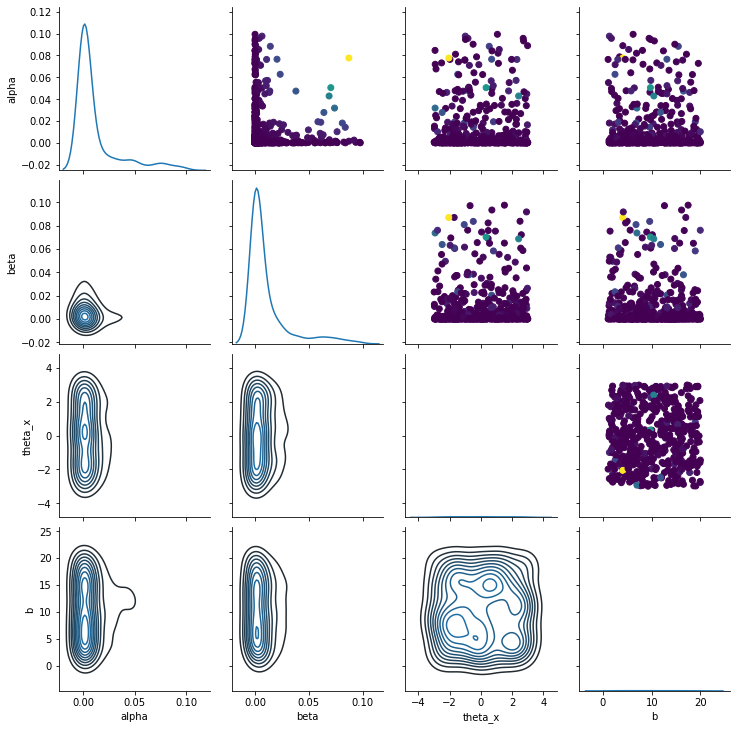

it 1, loss=9.84E+09


/Users/seanbittner/opt/anaconda3/envs/torch_nf/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/Users/seanbittner/opt/anaconda3/envs/torch_nf/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


it 10, loss=NAN
z (500, 4)
log_q_z (500,)


/Users/seanbittner/opt/anaconda3/envs/torch_nf/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


ValueError: 'c' argument has 500 elements, which is not acceptable for use with 'x' with size 0, 'y' with size 0.

<Figure size 432x288 with 0 Axes>

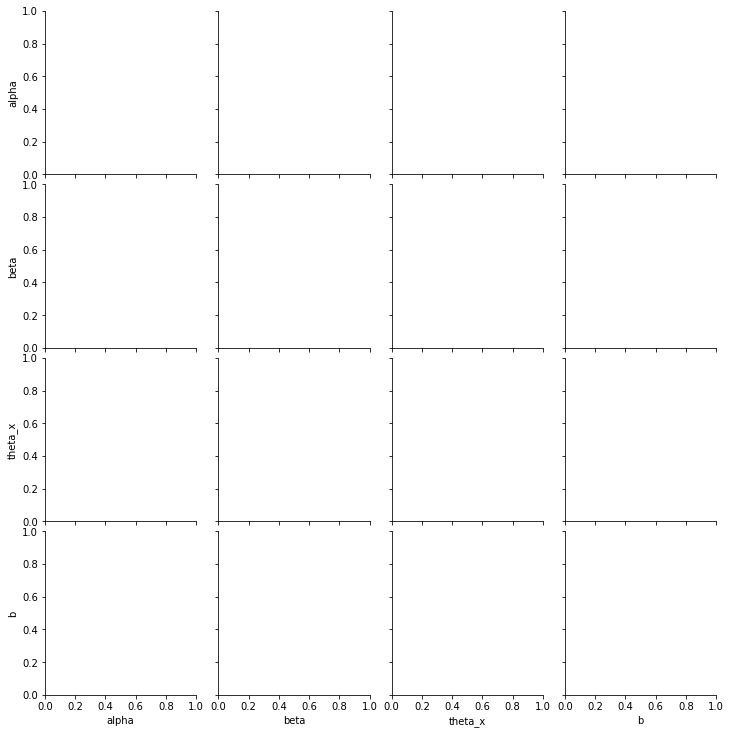

In [10]:
num_iters = 2000

D = 4
rs = 1
np.random.seed(rs)
torch.manual_seed(rs)
support_layer = ToInterval(D, lb, ub)
nf = NormFlow(D, arch_type, True, support_layer=support_layer)
cnf = ConditionedNormFlow(nf, x0.shape[1], hidden_layers)
losses = train_nde(cnf, x0, num_iters=num_iters)


In [11]:
losses = np.array(losses)

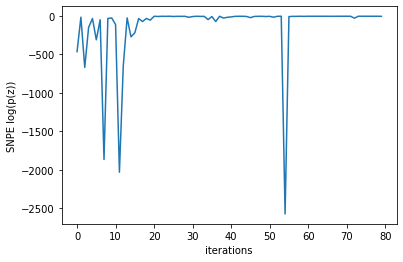

In [12]:
plt.figure()
plt.plot(-losses)
plt.xlabel('iterations')
plt.ylabel('SNPE log(p(z))')
plt.ylim([-10, 0])
plt.show()

In [14]:
x0_torch = torch.tensor(x0).float()
z, log_prob= cnf(x0_torch, N=100)